In [8]:
input_file='repapers2.xml'
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import numpy as np
from collections import Counter
import seaborn as sns
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import PunktSentenceTokenizer
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


tree= ET.parse(input_file)
root= tree.getroot()
#print(root.tag)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
import warnings
warnings.filterwarnings('ignore')

The next few steps were taken to get a csv file (uptil that its a repetition of the steps taken in retraction blog post).

In [9]:
lst1=root.findall('PubmedArticle/MedlineCitation/Article')
lst2=root.findall('PubmedArticle/PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
lst3=root.findall('PubmedArticle/MedlineCitation')
lst4=root.findall('PubmedArticle/PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]')
journal=[]
year=[]
month=[]
day=[]
authors=[]
instt=[]
article=[]
mesh=[]
abstract=[]
pubyear=[]
abb_authors=[]
pubmonth=[]
pubday=[]
re_year=[]
ret_year=[]
ret_month=[]
ret_date=[]

In [10]:
# get lists of journal name, article title, authors, affiliation
for item in lst1:
    j=item.find('Journal/Title')
    journal.append(j.text)
    
    a=item.find('ArticleTitle').text
    article.append(a)
    
    k=item.find('Journal/JournalIssue/PubDate/Year')
    if k is not None:
        pubyear.append(k.text)
    else:
        pubyear.append('None')
    
    m=item.find('Journal/JournalIssue/PubDate/Month')
    if m is not None:
        pubmonth.append(m.text)
    else:
        pubmonth.append('None')
    
    d=item.find('Journal/JournalIssue/PubDate/Day')
    if d is not None:
        pubday.append(d.text)
    else:
        pubday.append('None')
    
    x=item.findall('AuthorList/Author[@ValidYN="Y"]')
    
    author_small=[]
    affiliation_=[]
    short_name=[]
    for component in x:
        
        lname = ''
        fname = ''
        
        d=component.find('LastName')
        if d is not None:
            lname = d.text
        e = component.find('ForeName')
        if e is not None:
            fname = e.text
            name = fname + ' ' + lname 
        else:
            name=lname
        author_small.append(name)
        f=component.find('Initials')
        if f is not None:
            iname=f.text
            sname=iname + ' ' + lname
        else:
            sname = lname
        short_name.append(sname)

        aff=''
        c=component.findall('AffiliationInfo/Affiliation')
        if c is not None:
            for i in c:
            
                aff=i.text
                aff=aff 
        
        else:
            aff='None'
            
        
        affiliation_.append(aff)
    authors.append(','.join(author_small))
    instt.append(affiliation_)
    abb_authors.append(','.join(short_name))
    y=item.find('Abstract')
    if y is not None:
        w=y.findall('AbstractText')
        k=[]
        for i in w:
            z=i.text
            if z:
                k.append(z)
        l='\n'.join(k)    
        abstract.append(l)
    else:
        abstract.append(None)


# remving email add from affiliation
lstz=[]

for compo in instt:
    lsty=[]
    for item in compo:
        
        
   
        pattern=re.compile('.+\s.+@.+\.')
        if pattern.match(item):
        
            a=re.sub('[^ ]+@.+\.', '', item)
            
            if 'Electronic address:' in a:
                a=a.replace('Electronic address: ','')
            #introduces '','' twice in some cases
            lsty.append(a)
        else:
            lsty.append(item)
    lstz.append(lsty)



lsto=[]
for lsti in lstz[:10]:
    lstx=[]
    
    for i in lsti:
        if len(i)==1:
            lstx.append(i)
        else:
            z=i.split(', ')
            while z and z[-1] == '':
                z.pop()
            
            lstx.append(''.join(z[-1:]))
    lsto.append(lstx)
 

In [11]:
# finding publication year - using regular exp        
for item in lst2:
    y=item.text
    year.append(y)
for item in lst4:
    a=item.find('Month')
    if a is not None:
        month.append(a.text)
    else:
        month.append('None')
for  item in lst4:
    b=item.find('Day')
    if b is not None:
        day.append(b.text)
    else:
        day.append('None')
        
retract_year=[]           
for item in lst3:
    a=item.find('CommentsCorrectionsList/CommentsCorrections[@RefType="RetractionIn"]/RefSource')
    if a is not None:
        b=a.text
        retract_year.append(b)

    else:
        retract_year.append('None')
re_year=[]

ret_year=[]
for i in retract_year:
    pattern=re.compile('^.+\s\d{4}.+')
    if pattern.match(i):
        
        a=re.findall('\.\s(\d{4})', i)
        
        re_year.append(' '.join(a))
    else:
        pattern=re.compile('^.+\.\d{4}\.')
        if pattern.match(i):
            b=re.findall('\.(\d{4})\.',i)
            re_year.append(' '.join(b))
        else:
            re_year.append('None')

for i in retract_year:
    pattern=re.compile('^.+\s\d{4}.+')
    if pattern.match(i):
        
        a=re.findall('\.\s(\d{4}\s[A-Za-z]{3})', i)
        if a is not None:
            ret_year.append(' '.join(a))
        else:
            b=re.findall('\.\s(\d{4}\s[A-Za-z]{3})', i)
            ret_year.append(' '.join(b))
    
    else:
        pattern=re.compile('^.+\.\d{4}\.')
        if pattern.match(i):
            c=re.findall('\.(\d{4})\.',i)
            ret_year.append(' '.join(c))
        else:
            ret_year.append('None')

ret_month=[]
for i in retract_year:
    pattern=re.compile('^.+\s\d{4}.+')
    if pattern.match(i):
        
        a=re.findall('\.\s\d{4}\s([A-Za-z]{3})', i)
        if a is not None:
            ret_month.append(' '.join(a))
        
        else:
            ret_month.append('None')
    else:
        ret_month.append('None')
            
ret_date=[]
for i in retract_year:
    pattern=re.compile('^.+\s\d{4}.+')
    if pattern.match(i):
        
        a=re.findall('\.\s\d{4}\s[A-Za-z]{3}\s(\d+)', i)
        if a is not None:
            ret_date.append(' '.join(a))
        else:
            ret_date.append('None')
    else:
        ret_date.append('None')
    


In [12]:
# get keywords
keys=[]

for item in lst3:
    w=item.find('KeywordList')
    if w is not None:
        key=[]
        z=w.findall('Keyword')
        for component in z:
            
            y=component.text
            key.append(y)
        keyx=','.join(key)
        keys.append(keyx)

    else:
        keys.append(None)

In [13]:
# get mesh heading
descrip=[]
qualif=[]
for item in lst3:
    a=item.find('MeshHeadingList')
    if a is not None:
        b=a.findall('MeshHeading')
        des=[]
        qua = []
        for component in b:
            desc = component.find('DescriptorName')
            quals = component.findall('QualifierName')
            if desc is not None and desc.attrib['MajorTopicYN'] == 'Y':
                des.append(desc.text)
            elif quals:
                qualtexts = [qual.text for qual in quals if qual.attrib['MajorTopicYN'] == 'Y']
                if qualtexts:
                    qua.append(' '.join(qualtexts))
                    des.append(desc.text)
    else:
        des=['None']
        qua=['None']
    descrip.append(','.join(des))
    
    qualif.append(','.join (qua)) 


In [14]:
# checking sizes
print('article', len(article))
print('year', len(year))
print('authors', len(authors))
print('journal', len(journal))
print('instt', len(instt))
print('abstract', len(abstract))
print('keys', len(keys))
print('re_year', len(re_year))

article 6485
year 6485
authors 6485
journal 6485
instt 6485
abstract 6485
keys 6485
re_year 6485


In [15]:
#making a dataframe called retraction
retraction=pd.DataFrame({'article':article, 'year':year,'month':month,'day':day, 'authors':authors,'journal':journal, 'affiliation':instt, 'abstract':abstract,'keys':keys,  'retraction_year':re_year,'retraction_date':ret_year,'retraction_month':ret_month,'retraction_day':ret_date,'pub_year':pubyear, 'pub_month':pubmonth,'pub_day':pubday,'abbname':abb_authors})
print(retraction.head(2))

                                             article  year month day  \
0  Inhibition of KCNQ2/3 channels by HN38 and XE9...  2018    12   7   
1  Retracted: Long Noncoding RNA SOX2OT Accelerat...  2018    11  28   

                                             authors                 journal  \
0  Elizabeth Rodier,Zachary Niday,Klarita Doci,Le...  Molecular pharmacology   
1  Li Ma,Xingzhen Sun,Wenxia Kuai,Jian Hu,Yufang ...    DNA and cell biology   

                                         affiliation  \
0  [University of Connecticut., University of Con...   
1  [Department of Pediatrics, The Affiliated Huai...   

                                            abstract  \
0  Recent studies identified HN38 as a novel KCNQ...   
1  ATCC. www.lgcstandards-atcc.org/Products/All/C...   

                                keys retraction_year retraction_date  \
0  Epilepsy,Ion channels,Kv channels            2019        2019 Feb   
1  FOXP4,SOX2OT,Wilms’ tumor,miR-363            2018        

In [16]:
retraction.to_csv('retraction.csv')

In [17]:
x=pd.read_csv('retraction.csv')

In [18]:
x.head(2)

,Unnamed: 0,article,year,month,day,authors,journal,affiliation,abstract,keys,retraction_year,retraction_date,retraction_month,retraction_day,pub_year,pub_month,pub_day,abbname
0,0,Inhibition of KCNQ2/3 channels by HN38 and XE9...,2018,12,7,"Elizabeth Rodier,Zachary Niday,Klarita Doci,Le...",Molecular pharmacology,"['University of Connecticut.', 'University of ...",Recent studies identified HN38 as a novel KCNQ...,"Epilepsy,Ion channels,Kv channels",2019,2019 Feb,Feb,NaN,2018,Nov,30,"E Rodier,Z Niday,K Doci,L Wang,FJ Nan,ZB Gao,A..."
1,1,Retracted: Long Noncoding RNA SOX2OT Accelerat...,2018,11,28,"Li Ma,Xingzhen Sun,Wenxia Kuai,Jian Hu,Yufang ...",DNA and cell biology,"[""Department of Pediatrics, The Affiliated Hua...",ATCC. www.lgcstandards-atcc.org/Products/All/C...,"FOXP4,SOX2OT,Wilms’ tumor,miR-363",2018,2018 Dec,Dec,21,2018,Nov,27,"L Ma,X Sun,W Kuai,J Hu,Y Yuan,W Feng,X Lu"


In [19]:
retraction=x.drop('Unnamed: 0', axis=1)

In [20]:
retraction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6485 entries, 0 to 6484
Data columns (total 17 columns):
article             6485 non-null object
year                6485 non-null int64
month               6485 non-null int64
day                 6485 non-null int64
authors             6382 non-null object
journal             6485 non-null object
affiliation         6485 non-null object
abstract            6101 non-null object
keys                1054 non-null object
retraction_year     6483 non-null object
retraction_date     5858 non-null object
retraction_month    5858 non-null object
retraction_day      2482 non-null object
pub_year            6485 non-null object
pub_month           6485 non-null object
pub_day             6485 non-null object
abbname             6382 non-null object
dtypes: int64(3), object(14)
memory usage: 861.4+ KB


## abstract 

In [21]:
retraction2=retraction.drop(retraction[retraction['abstract'].isnull()].index)
retraction2=retraction2.drop(retraction2[retraction2['abstract'].str.contains('This article has been retracted')].index)

In [22]:
#retraction2[retraction2['abstract'].str.contains('ci p')]

In [23]:
doc=retraction2['abstract'].values.tolist()

In [24]:
#doc

As words like 'examined', 'discovered' do not give any differentiating info regarding different topics, I chose only words that are either noun, proper noun,or adjective. adjective such as 'western' which comes from western blot is important. p-53 and il-6 are examples of proper nouns.

In [25]:
nlp=spacy.load('en_core_web_sm')

In [26]:
def lemmatization(doc, allowed_pos=['NOUN','ADJ','PROPN']):
    lst1=[]
    for text in doc:
        doc_new = nlp(text) 
        lst2=[]
        for token in doc_new:
            if token.pos_ in allowed_pos:
                lst2.append(token.lemma_)
        lst1.append(lst2)
    return lst1

In [27]:
abstract_lemmatized=lemmatization(doc,allowed_pos=['NOUN','ADJ','PROPN'])

In [28]:
#abstract_lemmatized

In [29]:
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer('\s+|[<>=()-/]|[±°å]',gaps=True)
def remove_punctuation(text):
    lst=[]
    for doc in text:
        sent=' '.join(doc)
        lst.append(tokenizer.tokenize(sent))
    return(lst)

In [30]:
abstract_processed=remove_punctuation(abstract_lemmatized)

In [31]:
#abstract_processed

In [32]:
nltk_stopwords=stopwords.words('english')

In [33]:
len(nltk_stopwords)

179

In [34]:
bb_stopwords=['±','/','°','ii','iii','iv','researcher','meta','find','rate','case','literature','non','know','å','improve','contribute','great','give','influence','+','take','complete','initiate','vary','validate','recognition','preparation','recommend','none','proof','record','see','conduct','become','would','focus','end','accord','propose','correspond','observation','lack','basis','investigation','average','prove','prepare','note','follow','level','effect','control','datum','mechanism','indicate','mediate','test','role','-','author','independent','regard','novel','result','side','year','life','time','state','outcome','finding','use','self','expression','=','using','results','significantly','also','increase','may','levels','both','no','compare','our','show','group','however','study','data','high','observe','function','present','higher','different','one','two','well','potential','important','response','could','suggest','normal','including','three','+/-','inhibition','development','total','first','perform','new','change','reveal','inhibit','lower','investigate','without','respectively','specific','low','vs','95%','number','either','induction','within','involve','based','make','whether','whereas','furthermore','via','receive','shown','measure','similar','provide','less','formation','presence','evidence','differences','samples','related','determine','although','various','due','obtain','known','production','following','reduction','incidence','moreover','analyze','detect','common','many','included','%','followed','might','undergoing','require','isolate','weeks','highly','responses','difference','here','suggesting', 'thus','current','ratio','indicated','play','overall','caused','previously','increases','conducted','improved','greater','essential','research','approach','events','recent','assess','general','correlation','increasing','possible','better','versus','suggested','cause','review','analyses','given','leading','provides','resulting','severe','taken','considered','upon','suggests','established','alone','understaning','detection','together','previous','useful','occured','produced','randomly','reducing','reduce','exhibited','still','directly','especially','indicating','need','containing','experiments','presented','examine','according','relative','recently','main','selected','available','content','even','described','least','likely','approximately','generated','proposed','consistent','conclude','explore','additional','subsequent','since','highest','promote','future','plus','evaluation','good','assessment','unclear','markedly','variety','causes','publish','years','prevent','provide','altered','stimulate','calculate','made','design','lead','necessary','needed','another','severity','shows','knowledge','therefore','understand','able','develope','measure','specifically','particularly', 'along','much','occurs','remain','potentially','finally','include','widely', 'importance','relatively','involving','fully','appears','significant','used','found','demonstrate','among','identify','method','evaluate','early','several','report','decrease','confirm','plays','aim','seen','define','strategy','analysis','mean','represent','successfully','problem','help','predict','differ','partially','estimate','search','contributes','noted','serve','sufficient','way','print', 'article', 'publisher']

In [35]:
# checking if any duplicates are there
p=Counter(bb_stopwords)
x=pd.Series(p)
#x

In [36]:
# adding stopwords
nltk_stopwords.extend(bb_stopwords)
len(nltk_stopwords)

520

In [37]:
#nltk_stopwords

In [38]:
def remove_stopwords(doc):
    lst=[]
    for text in doc:
        lst2=[]
        for word in text: 
            word=word.lower()
            if word not in nltk_stopwords:
                lst2.append(word)
        lst.append(lst2)
    return lst



In [39]:
abstract_no_stop=remove_stopwords(abstract_processed)

In [40]:
#abstract_no_stop

In [41]:
from gensim.models.phrases import Phrases, Phraser

In [42]:
bi_phrases=Phrases(abstract_processed,min_count=5,threshold=10)
bigram = Phraser(bi_phrases)

def dimers(doc):
    lst2=[]
    for text in doc:
        di = bigram[text]
        #print(di)
        lst2.append(di)
    return lst2

In [43]:
abstract_bigram=dimers(abstract_no_stop)

In [44]:
#abstract_bigram

In [45]:
def abstract_bigram_clean(doc):
    lst=[]
    for text in doc:
        lst2=[]
        for word in text:
            if not word.isdigit() and len(word)>1:
                lst2.append(word)
        lst.append(lst2)
    return lst

In [46]:
abstract_clean=abstract_bigram_clean(abstract_bigram)

In [7]:
#abstract_clean

In [47]:
import itertools
abstract_terms=list(itertools.chain.from_iterable(abstract_clean))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [48]:
a=Counter(abstract_terms)
b=pd.Series(a)
c=b.sort_values(ascending=False)
#c

In [71]:
c.count()

35155

In [50]:
d=pd.DataFrame({'num':c})
#d

In [73]:
d[d['num']>1].count()

num    23157
dtype: int64

In [74]:
d[d['num']>5].count()

num    12415
dtype: int64

In [75]:
d[d['num']>9].count()

num    7873
dtype: int64

making a dictionary where I kept words that come at least twice and not more than in 20% of the documents

In [ ]:
# create a dictionary 
from gensim.corpora import Dictionary
dictionary = Dictionary(abstract_clean)
dictionary.filter_extremes(no_below=2, no_above=0.2)
# convert the dictionary into the bag-of-words (BoW)/document term matrix

corpus = [dictionary.doc2bow(text) for text in abstract_clean]

In [77]:
# instantiating an lda model
LDA = gensim.models.ldamodel.LdaModel 

In [ ]:
def calculate_coherence(dictionary, corpus, texts, start, stop, step):
    coherence_scores=[]
    models=[]
    for num_topics in range(start,stop,step):
        model=LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        models.append(model)
        coherence_lda=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence=coherence_lda.get_coherence()
        coherence_scores.append(coherence)
    return models,coherence_scores

In [104]:
models, coherence_scores = calculate_coherence(dictionary=dictionary, corpus=corpus, texts=abstract_clean, start=2, stop=40, step=3)

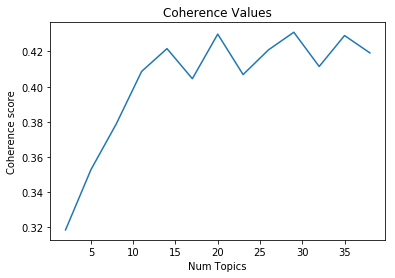

In [105]:
# plot graph
stop=40; start=2; step=3;
x = range(start, stop, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Values")
plt.show()

In [113]:
for no, c_v in zip(x,coherence_values):
    print('No. of topics:',no,'has coherence value:',round(c_v,3))

No. of topics: 2 has coherence value: 0.319
No. of topics: 5 has coherence value: 0.353
No. of topics: 8 has coherence value: 0.379
No. of topics: 11 has coherence value: 0.409
No. of topics: 14 has coherence value: 0.422
No. of topics: 17 has coherence value: 0.405
No. of topics: 20 has coherence value: 0.43
No. of topics: 23 has coherence value: 0.407
No. of topics: 26 has coherence value: 0.421
No. of topics: 29 has coherence value: 0.431
No. of topics: 32 has coherence value: 0.411
No. of topics: 35 has coherence value: 0.429
No. of topics: 38 has coherence value: 0.419


In [114]:
lda_model_abstract3 = LDA(corpus=corpus,id2word=dictionary, num_topics=14, 
                      random_state=10,chunksize=6485,passes=100)

In [138]:
from gensim.test.utils import datapath

temp_file = datapath("model")
lda_model_abstract3.save(temp_file)

In [ ]:
pyLDAvis.enable_notebook()

In [115]:
vis = pyLDAvis.gensim.prepare(lda_model_abstract3, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.183495  0.062088       1        1  10.166998
4     -0.236661  0.141637       2        1   9.464903
7     -0.159479  0.130350       3        1   9.075603
10    -0.187621 -0.053240       4        1   8.993103
12     0.067030 -0.207238       5        1   8.735045
11    -0.189093  0.064906       6        1   8.428452
6      0.226320  0.103414       7        1   7.910015
3     -0.147086 -0.135276       8        1   7.125290
8      0.164316  0.085246       9        1   6.368844
13     0.120865  0.007553      10        1   5.906406
2     -0.001182 -0.138638      11        1   4.923086
1      0.093849 -0.054369      12        1   4.893948
0      0.080432  0.059712      13        1   4.400873
5     -0.015185 -0.066145      14        1   3.607434, topic_info=      Category         Freq                          Term        Total  \
term                                                                     
735    Default  1433.000000                         tumor  1433.000000   
126    Default  2286.000000                          gene  2286.000000   
277    Default   782.000000                           mir   782.000000   
1626   Default   787.000000                            il   787.000000   
887    Default  1314.000000                    activation  1314.000000   
1758   Default   532.000000                            ci   532.000000   
1382   Default  1171.000000                         mouse  1171.000000   
31     Default  1114.000000                        cancer  1114.000000   
695    Default   948.000000                     apoptosis   948.000000   
934    Default   868.000000                          risk   868.000000   
891    Default   557.000000                           akt   557.000000   
1339   Default   630.000000                       surgery   630.000000   
854    Default  1037.000000                       pathway  1037.000000   
1735   Default   321.000000                          ci_p   321.000000   
911    Default   580.000000               phosphorylation   580.000000   
574    Default  1112.000000                      receptor  1112.000000   
1486   Default   445.000000                         brain   445.000000   
15073  Default   451.000000                        kappab   451.000000   
2      Default  1699.000000                      activity  1699.000000   
373    Default   460.000000                            nf   460.000000   
1134   Default   394.000000                 breast_cancer   394.000000   
802    Default   602.000000                   association   602.000000   
2070   Default   651.000000                     cell_line   651.000000   
2528   Default   529.000000                        kinase   529.000000   
421    Default   803.000000                           rat   803.000000   
451    Default   471.000000                        domain   471.000000   
15     Default  1563.000000                         human  1563.000000   
1936   Default   393.000000                        mutant   393.000000   
17     Default   738.000000                     inhibitor   738.000000   
754    Default   364.000000                       placebo   364.000000   
5092    Topic1    44.946957                         visit    45.834988   
3191    Topic1    43.946129                     emotional    44.845795   
15625   Topic1    33.231232                           cbf    34.119179   
3607    Topic1    31.288448                   oral_health    32.176380   
5240    Topic1    29.336338                  incontinence    30.224319   
6841    Topic1    28.356590                       aegypti    29.244526   
5248    Topic1    27.378284                           pfs    28.266249   
15949   Topic1    26.403278                          ddr2    27.291216   
4719    Topic1    26.393845              progression_free    27.282444   
5490    Topic1    24.455370                     scoliosis  

### list of topics
1-medical/clinical
2-cell cycle,cell proliferation and cell death
3-cancer
4-oxidative stress
5-biophysics and environment
6-immunology
7-medical related but differs from 1 and 9 as it has topic related to anesthesia and nausea
8-Genetics majorly related to genome, mutations and protein sequence
9-Medical/clinical but differs from 1 and 7 as it contains diabetes
10-Bone health 
11-mainly gut and absorption
12-central nervous system and cognition
13-genetic polymorphism
14-Growth factors and hormones (not very clear)


In [117]:
pyLDAvis.save_html(vis, '/Users/bhumi/testv1.4.03.html')